In [2]:
import h2o
from h2o.automl import H2OAutoML
import json
import pickle 
import pandas as pd
import random

In [3]:
#Create a random test train split between 60-80%
n = random.randrange(60, 80)

#read in data then split into train and test
data = pd.read_csv('/domino/datasets/local/wine-data/winequality.csv')
train = data[0:round(len(data)*n/100)]
test = data[train.shape[0]:]

In [4]:
print('H2O version -{}'.format(h2o.__version__))

#initailize local h2o
h2o.init()

H2O version -3.36.0.2
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfcx65_5w
  JVM stdout: /tmp/tmpfcx65_5w/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmpfcx65_5w/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_ubuntu_1enrlc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,976 Mb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


In [5]:
train.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
#Convert data to h2o frames
hTrain = h2o.H2OFrame(train)
hTest = h2o.H2OFrame(test)

# Identify predictors and response
x = hTrain.columns
y = "quality"
x.remove(y)

# Isolate target vasriable
hTrain[y] = hTrain[y]
hTest[y] = hTest[y]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
%%time
# Run AutoML for 5 base models (limited to 3 min max runtime by default)
aml = H2OAutoML(max_models=5, seed=1, max_runtime_secs=180)
aml.train(x=x, y=y, training_frame=hTrain)

AutoML progress: |
03:51:04.684: _train param, Dropping bad and constant columns: [type]

████
03:51:14.704: _train param, Dropping bad and constant columns: [type]

█
03:51:17.711: _train param, Dropping bad and constant columns: [type]

████
03:51:28.993: _train param, Dropping unused columns: [type]


03:51:29.995: _train param, Dropping bad and constant columns: [type]

██
03:51:35.999: _train param, Dropping bad and constant columns: [type]

████
03:51:47.3: _train param, Dropping unused columns: [type]


03:51:48.6: _train param, Dropping unused columns: [type]

█
03:51:49.12: _train param, Dropping unused columns: [type]

██
03:51:56.15: _train param, Dropping unused columns: [type]

██
03:52:01.20: _train param, Dropping unused columns: [type]

██
03:52:07.24: _train param, Dropping unused columns: [type]

█
03:52:11.27: _train param, Dropping unused columns: [type]

█
03:52:13.31: _train param, Dropping unused columns: [type]

███████████████████████████████████████| (done) 10

In [24]:
import seaborn as sns
import numpy as np
import pandas as pd
# sns.histplot(np.array(aml.leader.predict(hTest)))
a = aml.leader.predict(hTest)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='predict', ylabel='Count'>

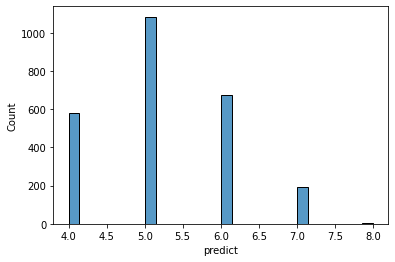

In [34]:
sns.histplot(a.as_data_frame()['predict'].apply(lambda x: np.around(x,0)))

<AxesSubplot:xlabel='predict', ylabel='Count'>

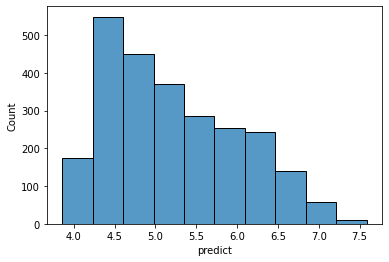

In [45]:
sns.histplot(a.as_data_frame().predict, bins = 10)

<AxesSubplot:xlabel='quality', ylabel='Count'>

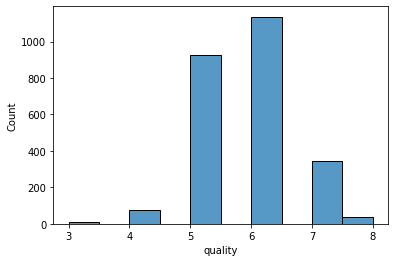

In [53]:
sns.histplot(test.quality.astype('float64'), bins =10)

In [52]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(test.quality, a.as_data_frame()['predict'])
mean_squared_error(test.quality, a.as_data_frame()['predict'])

1.0147360164977757